In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calibrate_camera():
    nx, ny = 9, 6
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def undistort(img, mtx, dist):
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistorted

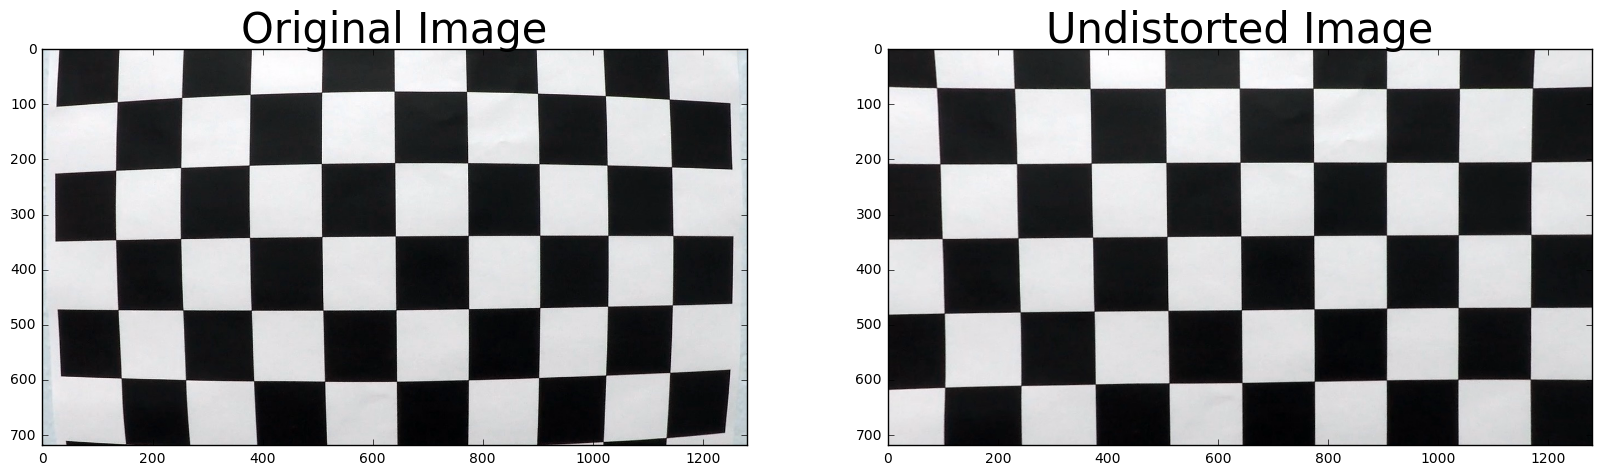

In [3]:
mtx, dist = calibrate_camera()

img = cv2.imread('camera_cal/calibration1.jpg')


img_undistorted = undistort(img, mtx, dist)

cv2.imwrite('camera_cal/calibration1_undist.jpg', img_undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

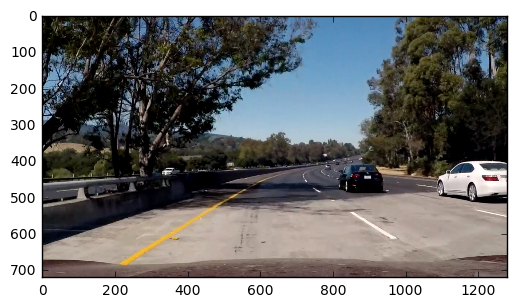

In [50]:
test_image = cv2.imread('test_images/test5.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)


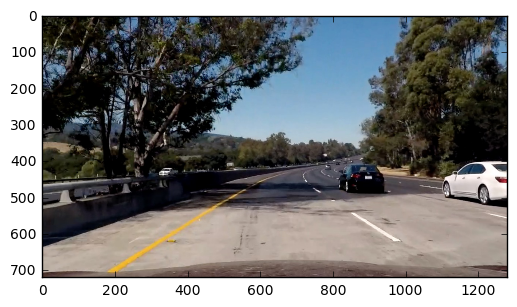

In [51]:
undist_ti = undistort(test_image, mtx, dist)
plt.imshow(undist_ti)

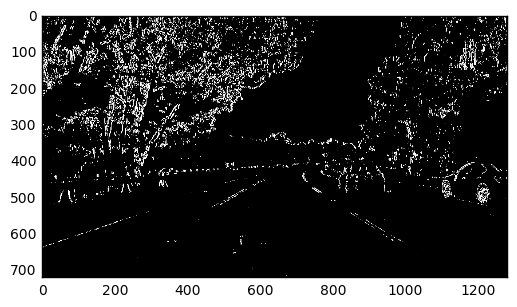

In [52]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

grad_binary_x_ti = abs_sobel_thresh(undist_ti, orient='x', thresh_min=30, thresh_max=100)
plt.imshow(grad_binary_x_ti, cmap='gray')

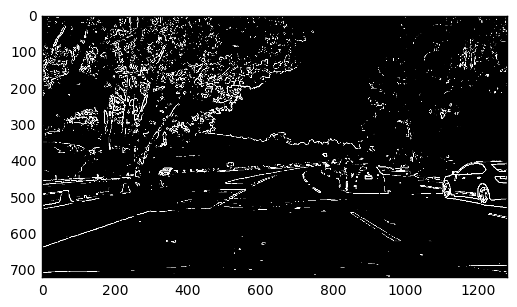

In [53]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

mag_binary_ti = mag_thresh(undist_ti, sobel_kernel=3, mag_thresh=(50, 200))
_, mag_binary_ti = cv2.threshold(mag_binary_ti,0,255,cv2.THRESH_BINARY)
mag_binary_ti = cv2.cvtColor(mag_binary_ti, cv2.COLOR_GRAY2RGB)
plt.imshow(mag_binary_ti, cmap='gray')

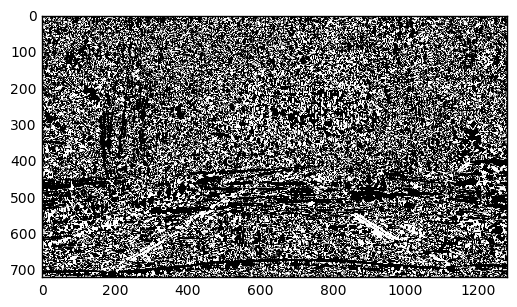

In [54]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output.astype('uint8')

dir_binary_ti = dir_threshold(undist_ti, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary_ti, cmap='gray')

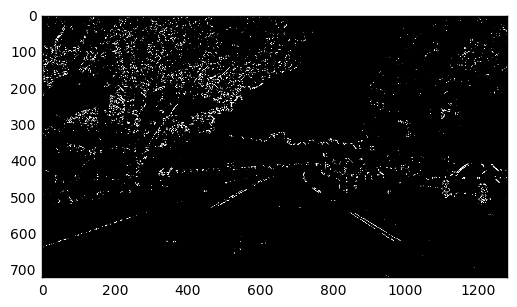

In [55]:
gradx = abs_sobel_thresh(undist_ti, orient='x', thresh_min=30, thresh_max=100)
grady = abs_sobel_thresh(undist_ti, orient='y', thresh_min=30, thresh_max=100)
mag_binary = mag_thresh(undist_ti, sobel_kernel=3, mag_thresh=(50, 200))
dir_binary = dir_threshold(undist_ti, sobel_kernel=15, thresh=(0.7, 1.2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

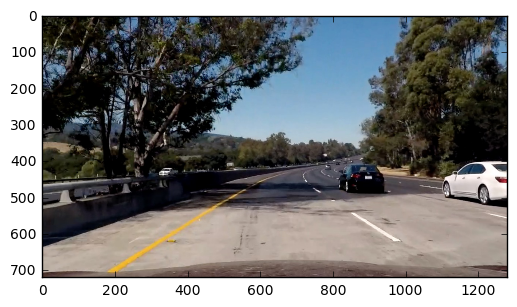

In [56]:
hard_image = cv2.imread('test_images/test5.jpg')
hard_image = cv2.cvtColor(hard_image, cv2.COLOR_BGR2RGB)
hard_image = undistort(hard_image, mtx, dist)
plt.imshow(hard_image)

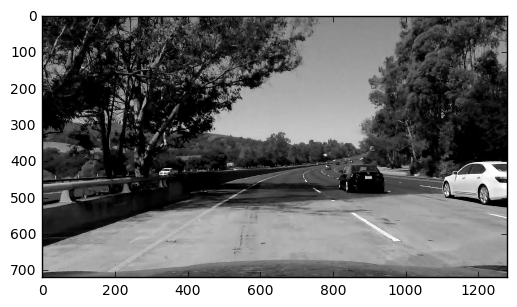

In [57]:
plt.imshow(hard_image[:,:,1], cmap='gray')

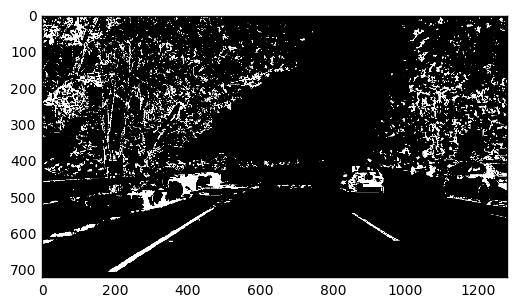

In [58]:
hard_hls = cv2.cvtColor(hard_image, cv2.COLOR_RGB2HLS)
s_channel = hard_hls[:,:,2]
binary_s = np.zeros_like(s_channel)
binary_s[(s_channel > 150) & (s_channel <= 255)] = 1
plt.imshow(binary_s, cmap='gray')

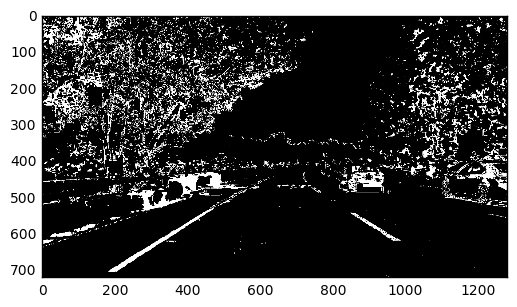

In [62]:
binary = np.zeros_like(combined)
binary[(combined == 1) | (binary_s == 1)] = 1
plt.imshow(binary, cmap='gray')

In [63]:
def process_image(image):
    image = undistort(image, mtx, dist)
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    hls_s = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    binary_s = np.zeros_like(hls_s)
    binary_s[(hls_s > 150) & (hls_s <= 255)] = 1
    binary = np.zeros_like(combined)
    binary[(combined == 1) | (binary_s == 1)] = 1
    _, image = cv2.threshold(binary,0,255,cv2.THRESH_BINARY)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

In [64]:
output = 'processed.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video processed.mp4
[MoviePy] Writing video processed.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:21<00:00,  3.18it/s]  0%|                                         | 1/1261 [00:00<07:21,  2.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed.mp4 

Wall time: 6min 22s
